<a href="https://colab.research.google.com/github/AkindeKadjo/Small-projects/blob/main/Stock_Price_Predict_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import SimpleRNN,Dense
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score

In [ ]:
#Load the Meta stock price data from CSV
prices = pd.read_excel('/content/drive/MyDrive/LinkedIn learning/FB-stock-prices.xlsx')
prices.head()

,Date,Price
0,2021-01-04,269
1,2021-01-05,271
2,2021-01-06,263
3,2021-01-07,269
4,2021-01-08,268


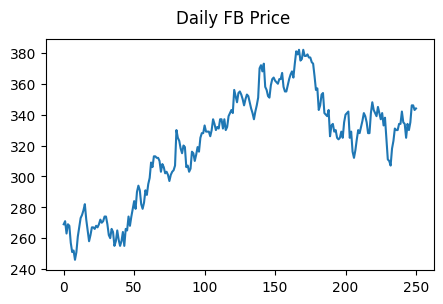

In [ ]:
# Plot the data to visualize the stock price
plt.figure(figsize=(5,3)).suptitle("Daily FB Price", fontsize=12)
plt.plot(prices["Price"])
plt.show()

#RNN

##Prepare the dataset

In [ ]:
# Scale the Data
scaler = StandardScaler()
scaled_prices=scaler.fit_transform(prices[["Price"]].values)
#Split data into Training and Test sets
total_size = len(scaled_prices)
#Test dataset size
test_size = 50
#Training dataset size
train_size = total_size - test_size

training_prices = scaled_prices[0:train_size,:]
test_prices = scaled_prices[train_size:,:]
print(training_prices.shape, test_prices.shape)

(201, 1) (50, 1)


In [ ]:
#Prepare RNN Dataset. 
#Each data point (X) is linked to the previous data points of size=lookback
#The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback -1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

In [ ]:
#lookback for 25 previous days
lookback=25

#Create X and Y for training and testing
train_req_x, train_req_y = create_rnn_dataset(training_prices,lookback)
test_req_x, test_req_y = create_rnn_dataset(test_prices,lookback)

#Reshape for use with RNN
train_req_x = np.reshape(train_req_x, 
                         (train_req_x.shape[0],1, train_req_x.shape[1]))
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#RNN model

In [ ]:
##I'm creating a function that will output the metrics for my model prediction evaluation
#creating a data frame output of the metrics
def res_regression(model,xtest,ytest,xtrain,ytrain, label='X Regression'):
  """Output regression metrics for both the test and the train data"""
 
  ## Get Predictions
  test_pred = model.predict(xtest)
  train_pred = model.predict(xtrain)
  ## Creating a header
  print('---'*20)
  print(f"[i] REPORT FOR: {label}")
  print('---'*20)
  #test metrics
  mse_test = mean_squared_error(ytest, test_pred)
  rmse_test = np.sqrt(mse_test).round(0)
  r2_test = r2_score(ytest, test_pred).round(4)
  res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
  #train metrics
  mse_train = mean_squared_error(ytrain, train_pred)
  rmse_train = np.sqrt(mse_train).round(0)
  r2_train = r2_score(ytrain, train_pred).round(4)
  res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
  res_df = pd.concat([res_df_test, res_df_train],axis = 1)
  return res_df

6/6 [==============================] - 0s 3ms/step
------------------------------------------------------------
[i] REPORT FOR: RNN
------------------------------------------------------------
      Test data  Training data
RMSE     0.0000         0.0000
R2       0.2475         0.9512


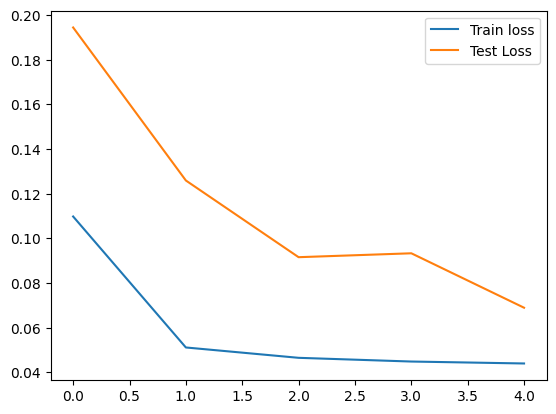

In [ ]:
tf.random.set_seed(3)

#Create a Keras Model
model=Sequential()
model.add(SimpleRNN(70, input_shape=(1,lookback)))
#model.add(Dense(10, activation='relu'))
model.add(Dense(1))

#Compile with Adam Optimizer. Optimize for minimum mean square error
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

#Train the model
history = model.fit(train_req_x, train_req_y, validation_data = (test_req_x, test_req_y),
             epochs=5, batch_size=1, verbose=0)
#Evaluate the model
#model.evaluate(test_req_x, test_req_y, verbose=1)

# Evaluate the linear regression model and print
print(res_regression(model,test_req_x, test_req_y, train_req_x,train_req_y, label='RNN'))
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

#Result

1/1 [==============================] - 0s 26ms/step


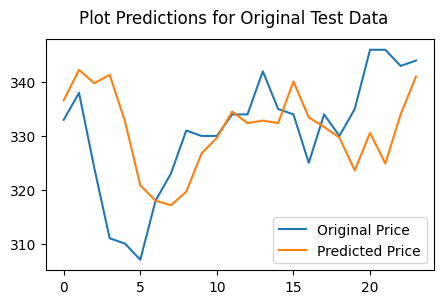

In [ ]:
#Predict on the test dataset
predict_on_test = model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_test = scaler.inverse_transform(predict_on_test)

#Extract original test values that map to the same dates on the predicted test values
orig_test_values = prices[["Price"]].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(5,3)).suptitle("Plot Predictions for Original Test Data", fontsize=12)
plt.plot(orig_test_values, label="Original Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()